# ENTRAINMENT - detrended timeseries, analysis of period over time, and stroboscopic map 
Paul Gerald Layague Sanchez (pglsanchez@gmail.com)<br>
Aulehla Lab, Developmental Biology Unit, EMBL Heidelberg

This script performs [wavelet analysis](https://doi.org/10.1101/2020.04.29.067744), and plots (1) the detrended timeseries with the periodic pulses, (2) period-time analysis, and (3) stroboscopic map from raw intensity timeseries of samples subjected to periodic drug pulses (in .txt). The stroboscopic map is delineated from entrainment, based on protocol by Paul François (paulf@physics.mcgill.ca), [Cross and Siggia](https://doi.org/10.1103/PhysRevE.72.021910) (**2005**), and [Isomura et al.](https://dx.doi.org/10.1101/gad.294546.116) (**2017**). Some parts are based on data analyses scripts by Gregor Mönke (moenke@embl.de).

Last updated by PGLS on 20200729 at 1531H

#### Modules are imported here:

In [1]:
from __future__ import division, print_function

import os
from os import path, walk

from pathlib import Path

import sys
sys.path.append(os.path.expanduser("~/PSM/progs/lib/"))

import numpy as np
from numpy import linspace, arange, zeros, array, sqrt, arctan, sin, cos
from numpy.random import normal, uniform, seed
from scipy.signal import savgol_filter
from scipy import ndimage, signal

import pandas as pd
import matplotlib.pylab as ppl
import seaborn as sns

from wavelet_analysis import *
from math import *
from matplotlib import rc, gridspec, cm
from skimage import io
from cycler import cycler

ppl.ion()

#### Parameters are specified here:

In [2]:
wdir = os.getcwd()
directory = wdir + '/entrainmentAnalysis/' # directory for output files

data_dir = wdir + '/SAMPLEDATA-2.0D_140+30_DAPT.txt' # path directory of .txt file, excluding filename.txt

dt = 10 # sampling interval in minutes
T_c = 240 # cut off period for mouse spreadouts in minutes, removes low frequency (high period) trends
offset = 0 # offset on start of experiment, if any
periods = linspace(100,250,200) # return 200 evenly spaced periods from 100 to 250
wAn = TFAnalyser(periods, dt, T_cut_off = T_c, vmax = 30) # adjust vmax to adjust the scale of wavelet power

reporter = 'LUVELU'
sample_loc = 'SO_DAPT' # specify details about the sample
drug = 'D' # for DAPT
drug_conc = 2 # drug concentration
nat_period = 14 # natural period (in mouse, around 140 mins), actual time = nat_period*dt
period_pulse = 17 # period of external pulse, actual time = period_pulse*dt
drug_duration = 3
med_duration = period_pulse - drug_duration

first_pulse = 14 # time point of the first pulse, actual time = first_pulse*dt
endpoint = 129 # last sampling time point, actual time = endpoint*dt

min_value = -0.2 # for plotting detrended signal
max_value = 0.2 # for plotting detrended signal
min_time = 50 # min time for plotting a section of detrended signal
max_time = 95 # max time for plotting a section of detrended signal

period_start_time = 65 # first time point to be considered for averaging periods from wavelet analysis
period_end_time = 86 # last time point to be considered for averaging periods from wavelet analysis + 1

t_inds = [20,40,60,80,100,120] # timepoints for polar plot, actual time in minutes = t_ind * dt
t_inds2 = np.arange(0,121,5) # timepoints for polar plot timelapse, actual time in minutes = t_ind * dt, from timepoint 0 to 121 with interval = 5 timepoints

In [3]:
# create a directory for output files

if not os.path.isdir(directory):    
    os.mkdir(directory)

if not os.path.isdir(directory + 'avePeriod'):    
    os.mkdir(directory + 'avePeriod')
    
if not os.path.isdir(directory + 'detrended_scale'):    
    os.mkdir(directory + 'detrended_scale')

if not os.path.isdir(directory + 'detrendedTimeseries'):    
    os.mkdir(directory + 'detrendedTimeseries')

if not os.path.isdir(directory + 'normalizedData'):    
    os.mkdir(directory + 'normalizedData')

if not os.path.isdir(directory + 'orderParameter'):    
    os.mkdir(directory + 'orderParameter')
    
if not os.path.isdir(directory + 'period'):    
    os.mkdir(directory + 'period')
    
if not os.path.isdir(directory + 'polarPlot'):    
    os.mkdir(directory + 'polarPlot')

if not os.path.isdir(directory + 'spectralDensity'):    
    os.mkdir(directory + 'spectralDensity')
    
if not os.path.isdir(directory + 'stroboscopic'):    
    os.mkdir(directory + 'stroboscopic')

In [4]:
def get_traj(col):
    traj = data[col]
    traj.dropna(inplace = True) # return series without null values, do operation in place (inplace=True)

    return traj

In [5]:
def figsave_to_tif(input_string,saving_dir): # to concatenate several images to make timelapse .tif
    wdir = os.getcwd()
    print("Working in",wdir)

    p = Path(wdir)
    figure_names = list( p.glob(input_string) )
    if len(figure_names) == 0:
        print('Found no input movie.. exiting!')
        sys.exit(1)
    figure_names.sort()

    figure_path = os.path.join( wdir, figure_names[0].name )
    figure = io.imread(figure_path, plugin="tifffile")

    mat = np.zeros([len(figure_names),figure.shape[0],figure.shape[1],figure.shape[2]], dtype = np.uint8)
    print(mat.shape)

    for index,k in enumerate(figure_names):

        figure_name = k.name # the roi movie file name

        figure_path = os.path.join( wdir, figure_name )
        print('Opening :', figure_name)
        mat[index,:,:,:] = io.imread(figure_path, plugin="tifffile")
        os.remove(figure_path)

    out_name = input_string.replace('2*','')[0:]
    out_path1 = os.path.join(directory + saving_dir, out_name)
    io.imsave(out_path1, mat)
    print('written',out_path1)


In [6]:
data = pd.read_csv(data_dir, sep = '\t') # read .txt file for oscillations

allTs = pd.DataFrame(index = data.index) # tabular data of all periods, with index same as data index
allPs = pd.DataFrame(index = data.index) # tabular data of all powers, with index same as data index
allphases = pd.DataFrame(index = data.index) # tabular data of all phases, with index same as data index
# allamplitudes = pd.DataFrame(index = data.index) # tabular data of all amplitudes, with index same as data index

# normalize intensities to maximum

max_intensities = data.max() # get maximum intensity per sample

for i in range(len(data.index)):
        
        for j in range(len(data.columns)):
            
            if j != 0:
                
                max_intensity = max_intensities[j]
                data.iloc[i,j] = data.iloc[i,j]/max_intensity

# save normalized timeseries
data.to_csv(str(directory) + 'normalizedData/' + str(reporter) + '_' + str(drug_conc) + '.0' + str(drug) + '_' + str(med_duration) + '0+' + str(drug_duration) + '0_' + str(sample_loc) + '.csv')

## Plotting the detrended signal with the drug pulses

Here the detrended signal of each sample is plotted with the drug pulses. The median of detrended signal and the interquartile range are also plotted.

In [7]:
# set color palette and specify number of colors based on number of samples, if not specified colors cycle after 6 samples

sns.set_style("ticks")
sns.despine()
sns.set_context("talk", font_scale = 1.5)

ncolors = len(data.columns) - 1
sns.set_palette("viridis", ncolors)

<Figure size 432x288 with 0 Axes>

/anaconda3/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


<Figure size 432x288 with 0 Axes>

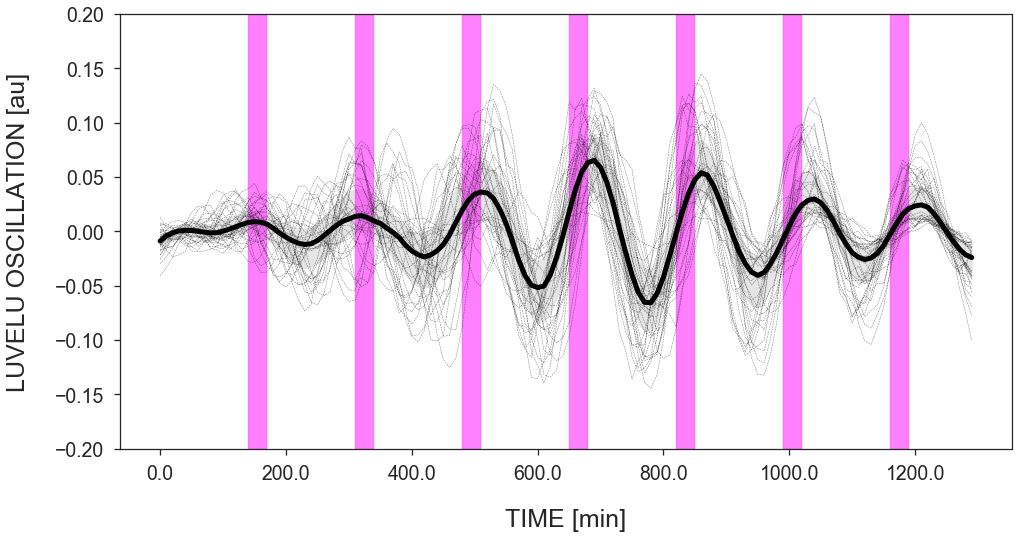

In [8]:
# from start to endpoint

ncolors = len(data.columns) - 1
sns.set_palette("viridis", ncolors)

fig = ppl.figure(1)
ppl.figure(figsize=(16,8)) # default size is 8,6
ppl.clf()
DETRENDax = ppl.gca()

a = first_pulse

for n in range(0,endpoint):
    if a <= endpoint:
        b = a + drug_duration
        DETRENDax.axvspan(a, b, alpha = 0.5, color = 'magenta')
        a = a + period_pulse

allDetrended = pd.DataFrame(index = data.index) 

for col in data.columns:
    
    if 'W' not in col: # W in column name -- sample
        continue
    traj = get_traj(col)
    wAn.compute_spectrum(traj, Plot = False) # if Plot = True, or removed, will show all power spectrum
    detrended_signal = wAn.sinc_detrend()
    
    DETRENDax.plot(detrended_signal, '--', lw = 0.5, alpha = 0.5, color='black')
    
    allDetrended[col] = detrended_signal

alldetrended_q1 = allDetrended.quantile(q = 0.25, axis = 1) # first quartile of all detrended signal
alldetrended_q3 = allDetrended.quantile(q = 0.75, axis = 1) # third quartile of all detrended signal
alldetrended_med = allDetrended.quantile(q = 0.5, axis = 1) # second quartile (median) of all detrended signal

alldetrended_q1 = savgol_filter(alldetrended_q1, 13,3)
alldetrended_q3 = savgol_filter(alldetrended_q3, 13,3)
alldetrended_med = savgol_filter(alldetrended_med, 13,3)    

DETRENDax.plot(alldetrended_med, '-', c = 'black', alpha = 1.0, lw = 5.0)
DETRENDax.fill_between(arange(len(alldetrended_q1)), alldetrended_q1, alldetrended_q3, alpha = 0.1, color = 'black') # can add (, label = 'LABEL') inside parentheses (after color) to specify label
DETRENDax.set_xlabel('TIME [min]', labelpad = 25, fontsize = 25)
DETRENDax.set_ylabel('LUVELU OSCILLATION [au]', labelpad = 25, fontsize = 25)
DETRENDax.set_ylim([min_value,max_value])
DETRENDax.set_xticklabels(DETRENDax.get_xticks()*dt)

savefig(str(directory) + 'detrended_scale/detrended_' + str(reporter) + '_' + str(drug_conc) + '.0' + str(drug) + '_' + str(med_duration) + '0+' + str(drug_duration) + '0_' + str(sample_loc) + '.pdf', bbox_inches = 'tight')

# export detrended timeseries
allDetrended.to_csv(str(directory) + 'detrendedTimeseries/' + str(reporter) + '_' + str(drug_conc) + '.0' + str(drug) + '_' + str(med_duration) + '0+' + str(drug_duration) + '0_' + str(sample_loc) + '.csv')

<Figure size 432x288 with 0 Axes>

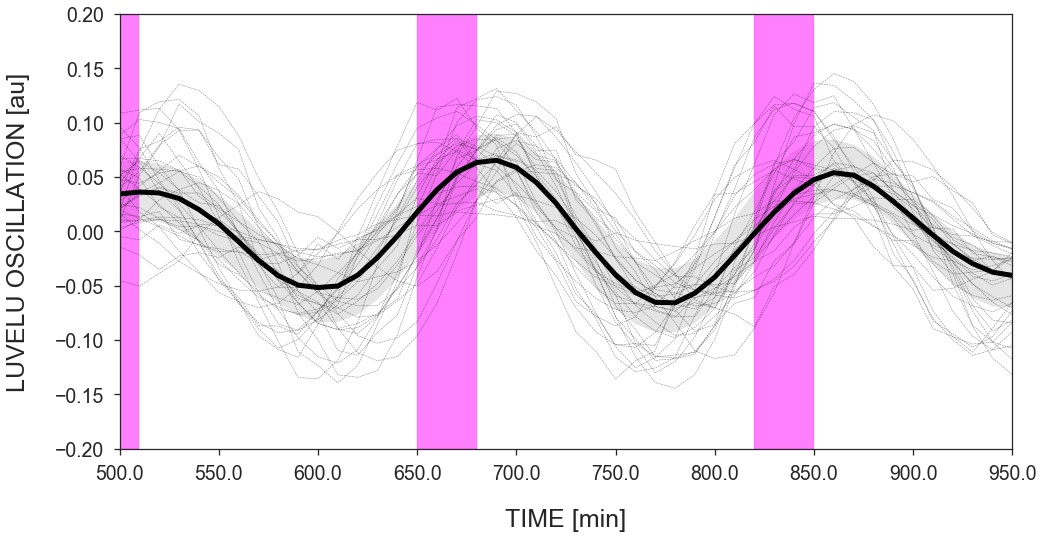

In [9]:
# from min_time to max_time

ncolors = len(data.columns) - 1
sns.set_palette("viridis", ncolors)

fig = ppl.figure(1)
ppl.figure(figsize=(16,8)) # default size is 8,6
ppl.clf()
DETRENDax = ppl.gca()

a = first_pulse

for n in range(0,endpoint):
    if a <= endpoint:
        b = a + drug_duration
        DETRENDax.axvspan(a, b, alpha = 0.5, color = 'magenta')
        a = a + period_pulse

allDetrended = pd.DataFrame(index = data.index) 

for col in data.columns:
    
    if 'W' not in col:
        continue
    traj = get_traj(col)
    wAn.compute_spectrum(traj, Plot = False) # if Plot = True, or removed, will show all power spectrum
    detrended_signal = wAn.sinc_detrend()
    
    DETRENDax.plot(detrended_signal, '--', lw = 0.5, alpha = 0.5, color='black')
    
    allDetrended[col] = detrended_signal

alldetrended_q1 = allDetrended.quantile(q = 0.25, axis = 1) # first quartile of all detrended signal
alldetrended_q3 = allDetrended.quantile(q = 0.75, axis = 1) # third quartile of all detrended signal
alldetrended_med = allDetrended.quantile(q = 0.5, axis = 1) # second quartile (median) of all detrended signal

alldetrended_q1 = savgol_filter(alldetrended_q1, 13,3)
alldetrended_q3 = savgol_filter(alldetrended_q3, 13,3)
alldetrended_med = savgol_filter(alldetrended_med, 13,3)    

DETRENDax.plot(alldetrended_med, '-', c = 'black', alpha = 1.0, lw = 5.0)
DETRENDax.fill_between(arange(len(alldetrended_q1)), alldetrended_q1, alldetrended_q3, alpha = 0.1, color = 'black') # can add (, label = 'LABEL') inside parentheses (after color) to specify label
DETRENDax.set_xlabel('TIME [min]', labelpad = 25, fontsize = 25)
DETRENDax.set_ylabel('LUVELU OSCILLATION [au]', labelpad = 25, fontsize = 25)
DETRENDax.set_xlim([min_time,max_time]) # change minimum and maximum x values
DETRENDax.set_ylim([min_value,max_value])
DETRENDax.set_xticklabels(DETRENDax.get_xticks()*dt)

savefig(str(directory) + 'detrended_scale/detrended_' + str(min_time) + '+' + str(max_time) + '_' + str(reporter) + '_' + str(drug_conc) + '.0' + str(drug) + '_' + str(med_duration) + '0+' + str(drug_duration) + '0_' + str(sample_loc) + '.pdf', bbox_inches = 'tight')

## Time-period analysis using wavelet analysis

Here the change in period during the entrainment experiment is monitored via wavelet analysis. Plotted are the periods (for individual samples, the median, and the interquartile range), and their corresponding wavelet power. The wavelet analysis pipeline used here is developed by Gregor Mönke (moenke@embl.de). For details, please refer to [this preprint](https://doi.org/10.1101/2020.04.29.067744).

Period with max power of 34.38 in sample  is 185.93
Period with max power of 37.73 in sample  is 151.26
Period with max power of 60.10 in sample  is 171.61
Period with max power of 51.54 in sample  is 171.61
Period with max power of 57.00 in sample  is 168.59
Period with max power of 56.37 in sample  is 185.18
Period with max power of 58.41 in sample  is 174.62
Period with max power of 57.19 in sample  is 175.38
Period with max power of 57.50 in sample  is 179.90
Period with max power of 41.99 in sample  is 157.29
Period with max power of 50.65 in sample  is 181.41
Period with max power of 52.13 in sample  is 170.10
Period with max power of 56.60 in sample  is 178.39
Period with max power of 48.75 in sample  is 173.87
Period with max power of 61.16 in sample  is 184.42
Period with max power of 51.70 in sample  is 170.85
Period with max power of 55.41 in sample  is 183.67
Period with max power of 53.38 in sample  is 182.91
Period with max power of 53.50 in sample  is 178.39
Period with 

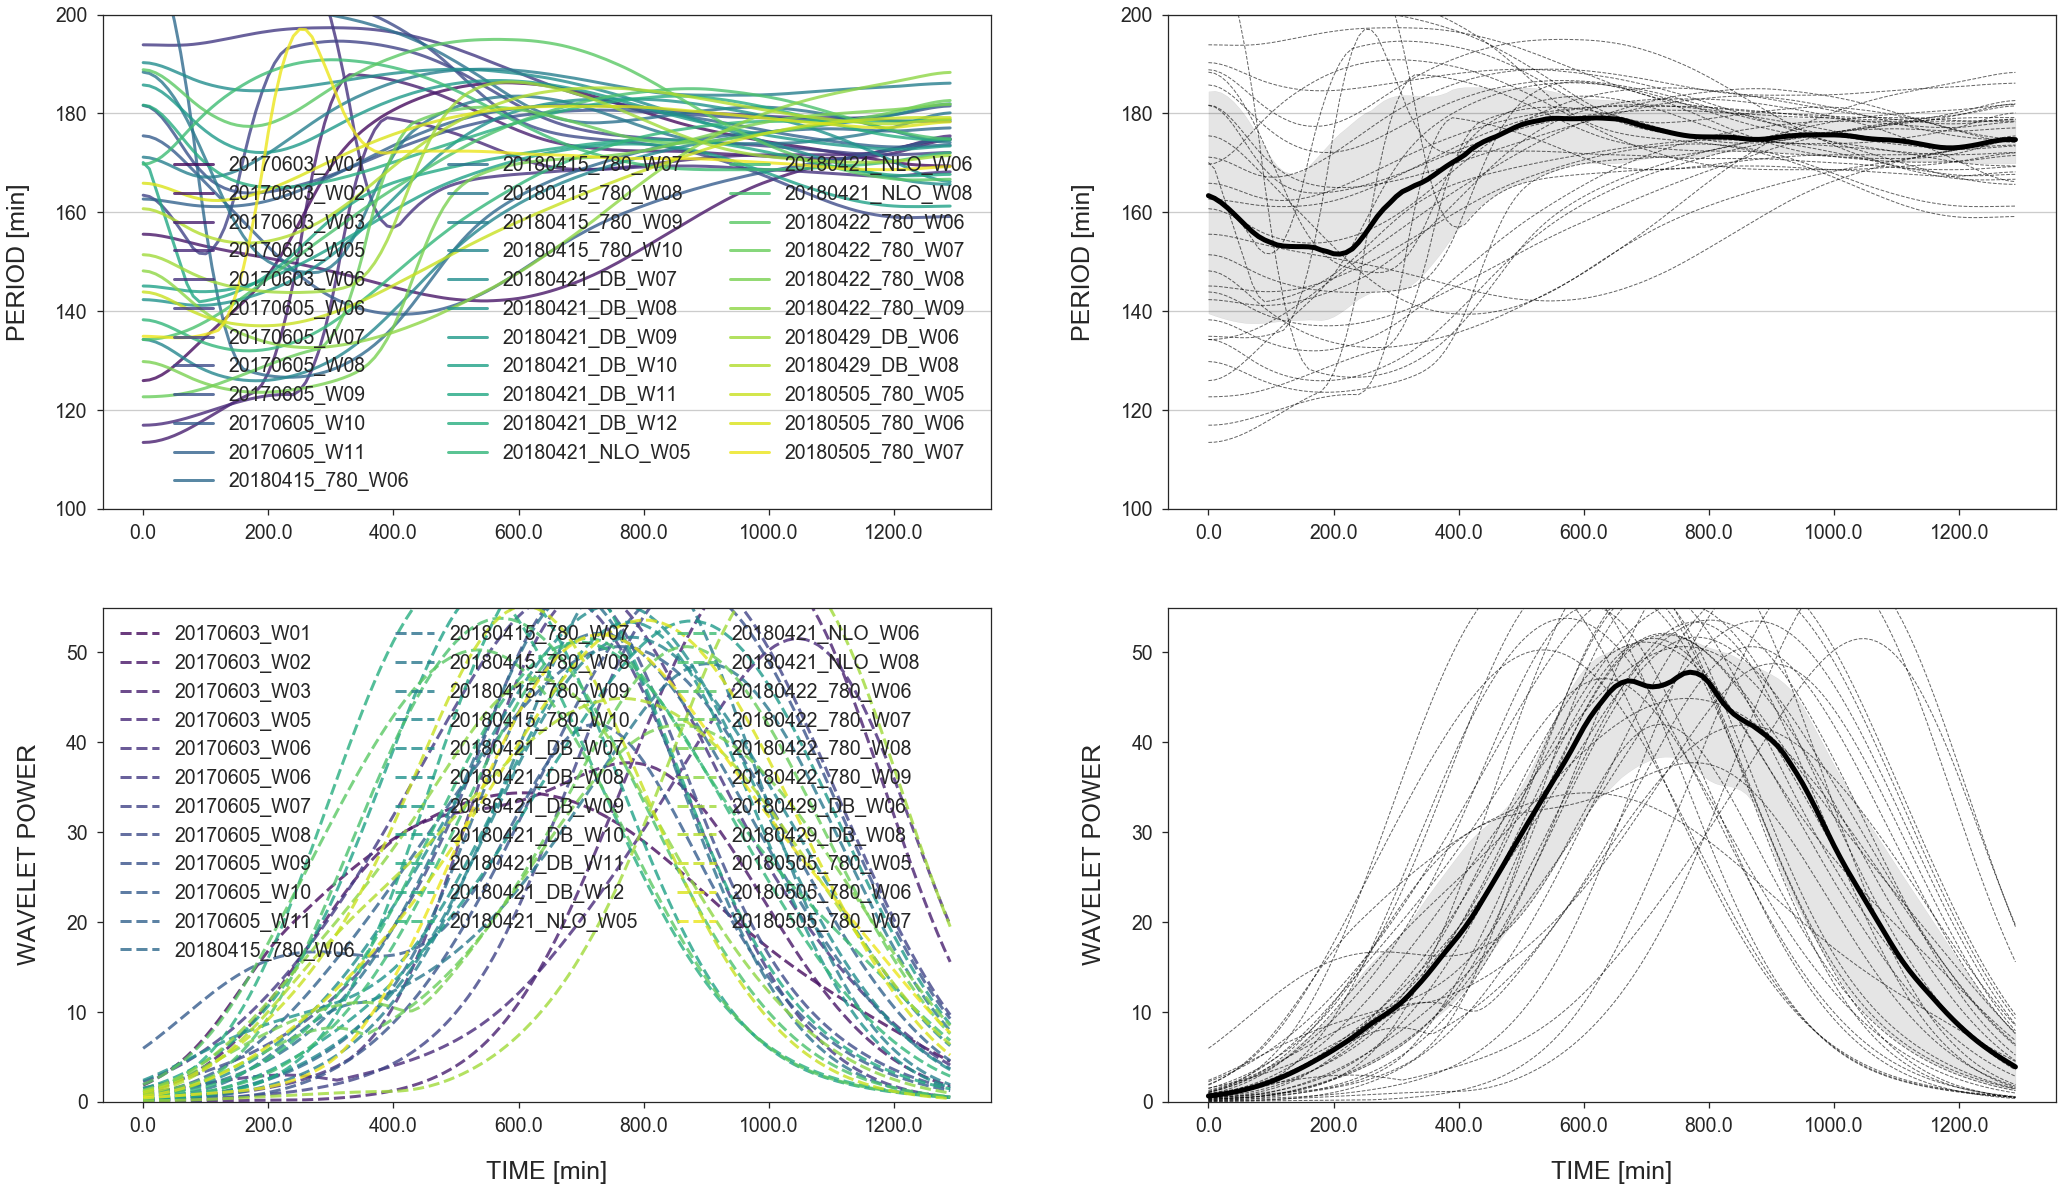

In [10]:
ncolors = len(data.columns) - 1
sns.set_palette("viridis", ncolors)

f1,axs1 = ppl.subplots(2,2, sharex = False, figsize = (35,20), num = 1)	# figure with 4 subplots (2,2) - 2 rows and 2 columns
ax1 = axs1[0,0]
ax2 = axs1[1,0]
ax3 = axs1[0,1]
ax4 = axs1[1,1]

for col in data.columns:
    if 'W' not in col: # ignore columns that do not correspond to sample trajectories
        continue
    traj = get_traj(col)
    wAn.compute_spectrum(traj, Plot = False)
    rdata = wAn.get_maxRidge() # has arrays for inds, power, ridge, time, and z 
    Ts = rdata['ridge'] # array for periods
    Ps = rdata['power']
    
    s = pd.Series(Ts) # 1d array of periods with axis labels 
    allTs[col] = s

    s = pd.Series(Ps) # 1d array of powers with axis labels
    allPs[col] = s

    ax1.plot(Ts, label = col, lw = 3, alpha = 0.8)
    ax2.plot(Ps, '--', label = col, lw = 3, alpha = 0.8)
    
ax1.legend(ncol = 3)
ax1.set_ylabel('PERIOD [min]', labelpad = 25, fontsize = 25)
ax1.set_ylim([100,200]) # change minimum and maximum y value, period, plotted
ax1.set_xticklabels(ax1.get_xticks()*dt)
ax1.yaxis.grid() # horizontal gridlines

ax2.legend(ncol = 3)
ax2.set_ylabel('WAVELET POWER', labelpad = 25, fontsize = 25)
ax2.set_ylim([0,55])
ax2.set_xlabel('TIME [min]', labelpad = 25, fontsize = 25)
ax2.set_xticklabels(ax2.get_xticks()*dt)

# plot quartile distribution of period across time

allTs_q1 = allTs.quantile(q = 0.25, axis = 1) # first quartile of all periods (Ts)
allTs_q3 = allTs.quantile(q = 0.75, axis = 1) # third quartile of all periods (Ts)
allTs_med = allTs.quantile(q = 0.5, axis = 1) # second quartile = median of all periods (Ts)

allTs_q1 = savgol_filter(allTs_q1, 13,3)
allTs_q3 = savgol_filter(allTs_q3, 13,3)
allTs_med = savgol_filter(allTs_med, 13,3)

for col in data.columns:
    if 'W' not in col: # ignore columns that do not correspond to sample trajectories
        continue
    traj = get_traj(col)
    wAn.compute_spectrum(traj, Plot = False)
    rdata = wAn.get_maxRidge() # has arrays for inds, power, ridge, time, and z 
    Ts = rdata['ridge'] # array for periods
    Ps = rdata['power']
    
    s = pd.Series(Ts) # 1d array of periods with axis labels 
    allTs[col] = s

    s = pd.Series(Ps) # 1d array of powers with axis labels
    allPs[col] = s

    ax3.plot(Ts, '--', lw = 1, alpha = 0.6, color='black')
    ax4.plot(Ps, '--', lw = 1, alpha = 0.6, color = 'black')
    
ax3.plot(allTs_med, '-', c = 'black', alpha = 1.0, lw = 5.0)
ax3.fill_between(arange(len(allTs_q1)), allTs_q1, allTs_q3, alpha = 0.1, color = 'black') # can add (, label = 'LABEL') inside parentheses (after 'blue') to specify label
ax3.set_ylabel('PERIOD [min]', labelpad = 25, fontsize = 25)
ax3.set_ylim([100,200])  # change minimum and maximum y value, period, plotted
ax3.set_xticklabels(ax3.get_xticks()*dt)
ax3.yaxis.grid() # horizontal gridlines

# plot quartile distribution of wavelet power across time

allPs_q1 = allPs.quantile(q = 0.25, axis = 1) # first quartile of all wavelet powers (Ps)
allPs_q3 = allPs.quantile(q = 0.75, axis = 1) # third quartile of all wavelet powers (Ps)
allPs_med = allPs.quantile(q = 0.5, axis = 1) # second quartile = median of all wavelet powers (Ps)

allPs_q1 = savgol_filter(allPs_q1, 13,3)
allPs_q3 = savgol_filter(allPs_q3, 13,3)
allPs_med = savgol_filter(allPs_med, 13,3)

ax4.plot(allPs_med, '-', c = 'black', alpha = 1.0, lw = 5.0)
ax4.fill_between(arange(len(allPs_q1)), allPs_q1, allPs_q3, alpha = 0.1, color = 'black') # can add (, label = 'LABEL') inside parentheses (after 'blue') to specify label
ax4.set_ylabel('WAVELET POWER', labelpad = 25, fontsize = 25)
ax4.set_ylim([0,55])
ax4.set_xlabel('TIME [min]', labelpad = 25, fontsize = 25)
ax4.set_xticklabels(ax4.get_xticks()*dt) # you have ticks only for x-axis, alternative to last two lines

savefig(str(directory) + 'period/period_' + str(reporter) + '_' + str(drug_conc) + '.0' + str(drug) + '_' + str(med_duration) + '0+' + str(drug_duration) + '0_' + str(sample_loc) + '.pdf', bbox_inches = 'tight')

Period with max power of 34.38 in sample  is 185.93
Period with max power of 37.73 in sample  is 151.26
Period with max power of 60.10 in sample  is 171.61
Period with max power of 51.54 in sample  is 171.61
Period with max power of 57.00 in sample  is 168.59
Period with max power of 56.37 in sample  is 185.18
Period with max power of 58.41 in sample  is 174.62
Period with max power of 57.19 in sample  is 175.38
Period with max power of 57.50 in sample  is 179.90
Period with max power of 41.99 in sample  is 157.29
Period with max power of 50.65 in sample  is 181.41
Period with max power of 52.13 in sample  is 170.10
Period with max power of 56.60 in sample  is 178.39
Period with max power of 48.75 in sample  is 173.87
Period with max power of 61.16 in sample  is 184.42
Period with max power of 51.70 in sample  is 170.85
Period with max power of 55.41 in sample  is 183.67
Period with max power of 53.38 in sample  is 182.91
Period with max power of 53.50 in sample  is 178.39
Period with 

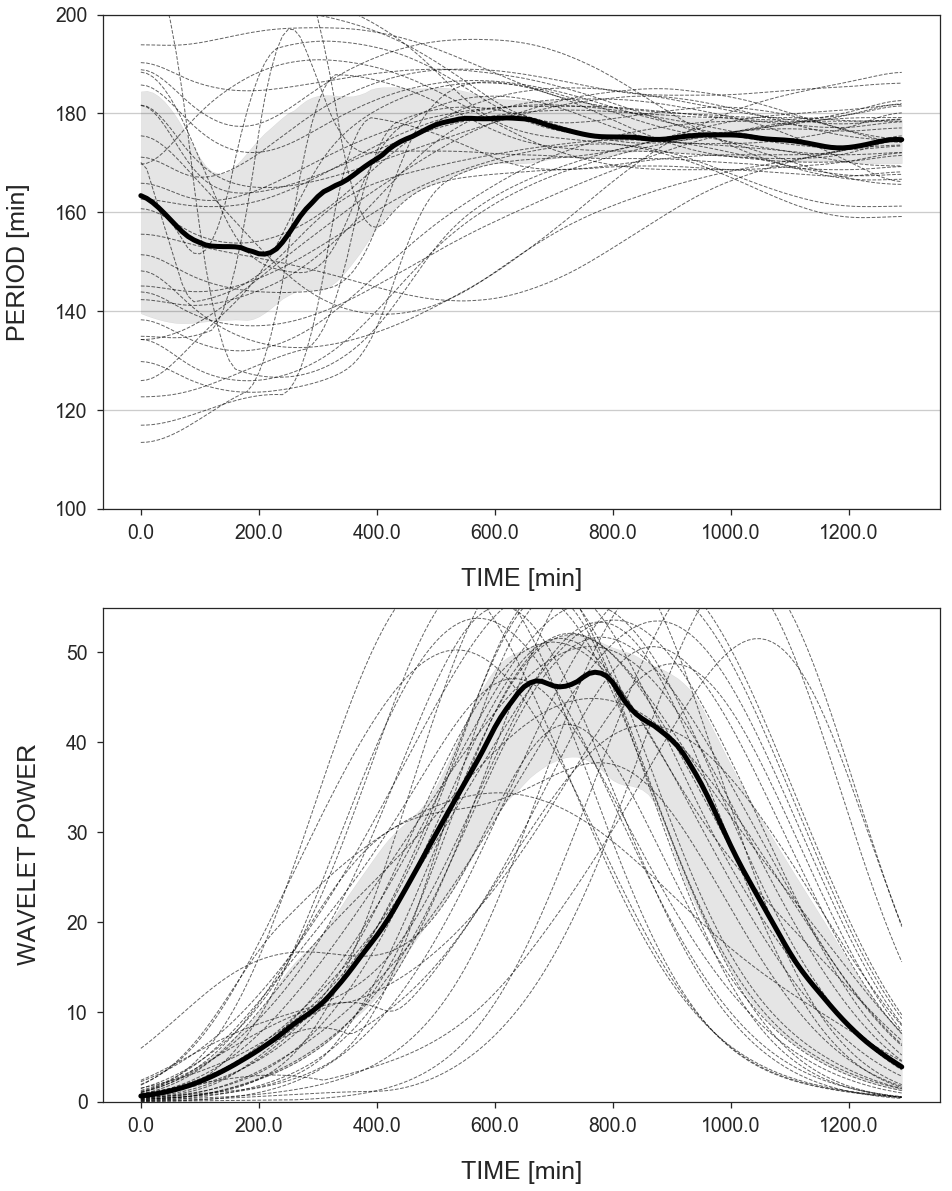

In [11]:
ncolors = len(data.columns) - 1
sns.set_palette("viridis", ncolors)

f1,axs1 = ppl.subplots(2,1, sharex = False, figsize = (15,20), num = 1) # figure with 2 subplots (2,1) - 2 rows and 1 column
ax1 = axs1[0]
ax2 = axs1[1]

# plot quartile distribution of period across time

allTs_q1 = allTs.quantile(q = 0.25, axis = 1) # first quartile of all periods (Ts)
allTs_q3 = allTs.quantile(q = 0.75, axis = 1) # third quartile of all periods (Ts)
allTs_med = allTs.quantile(q = 0.5, axis = 1) # second quartile = median of all periods (Ts)

allTs_q1 = savgol_filter(allTs_q1, 13,3)
allTs_q3 = savgol_filter(allTs_q3, 13,3)
allTs_med = savgol_filter(allTs_med, 13,3)

for col in data.columns:
    if 'W' not in col: # ignore columns that do not correspond to well traces
        continue
    
    traj = get_traj(col)
    wAn.compute_spectrum(traj, Plot = False)
    rdata = wAn.get_maxRidge() # has arrays for inds, power, ridge, time, and z 
    Ts = rdata['ridge'] # array for periods
    Ps = rdata['power']
    
    s = pd.Series(Ts) # 1d array of periods with axis labels 
    allTs[col] = s
    
    s = pd.Series(Ps) # 1d array of powers with axis labels
    allPs[col] = s
    
    ax1.plot(Ts, '--', lw = 1, alpha = 0.6, color='black')
    ax2.plot(Ps, '--', lw = 1, alpha = 0.6, color = 'black')
    
ax1.plot(allTs_med, '-', c = 'black', alpha = 1.0, lw = 5.0)
ax1.fill_between(arange(len(allTs_q1)), allTs_q1, allTs_q3, alpha = 0.1, color = 'black') # can add (, label = 'LABEL') inside parentheses (after 'blue') to specify label
ax1.set_ylabel('PERIOD [min]', labelpad = 25, fontsize = 25)
ax1.set_ylim([100,200]) # change minimum and maximum y value, period, plotted
ax1.set_xlabel('TIME [min]', labelpad = 25, fontsize = 25)
ax1.set_xticklabels(ax1.get_xticks()*dt)
ax1.yaxis.grid() # horizontal gridlines

# ax1.set_ticklabels([]) # you have ticks only for x-axis, alternative to last two lines

# plot quartile distribution of wavelet power across time

allPs_q1 = allPs.quantile(q = 0.25, axis = 1) # first quartile of all wavelet powers (Ps)
allPs_q3 = allPs.quantile(q = 0.75, axis = 1) # third quartile of all wavelet powers (Ps)
allPs_med = allPs.quantile(q = 0.5, axis = 1) # second quartile = median of all wavelet powers (Ps)

allPs_q1 = savgol_filter(allPs_q1, 13,3)
allPs_q3 = savgol_filter(allPs_q3, 13,3)
allPs_med = savgol_filter(allPs_med, 13,3)

ax2.plot(allPs_med, '-', c = 'black', alpha = 1.0, lw = 5.0)
ax2.fill_between(arange(len(allPs_q1)), allPs_q1, allPs_q3, alpha = 0.1, color = 'black') # can add (, label = 'LABEL') inside parentheses (after 'blue') to specify label
ax2.set_ylabel('WAVELET POWER', labelpad = 25, fontsize = 25)
ax2.set_ylim([0,55])
ax2.set_xlabel('TIME [min]', labelpad = 25, fontsize = 25)
ax2.set_xticklabels(ax2.get_xticks()*dt)
# ax2.set_ticklabels([]) # you have ticks only for x-axis, alternative to last two lines

savefig(str(directory) + 'period/period_all_' + str(reporter) + '_' + str(drug_conc) + '.0' + str(drug) + '_' + str(med_duration) + '0+' + str(drug_duration) + '0_' + str(sample_loc) + '.pdf', bbox_inches = 'tight')

In [12]:
# for calculating average period for a range of time

averaged_Ts = allTs.iloc[range(period_start_time,period_end_time),:]
average_Ts = averaged_Ts.mean()
average_Ts = pd.DataFrame(average_Ts)
# average_Ts.to_csv(r'/Users/pglsanchez/Desktop/average_Ts.csv')
average_Ts.to_csv(str(directory) + 'avePeriod/' + str(reporter) + '_' + str(drug_conc) + '.0' + str(drug) + '_' + str(med_duration) + '0+' + str(drug_duration) + '0_' + str(sample_loc) + '.csv')

Period with max power of 34.38 in sample  is 185.93
Period with max power of 37.73 in sample  is 151.26
Period with max power of 60.10 in sample  is 171.61
Period with max power of 51.54 in sample  is 171.61
Period with max power of 57.00 in sample  is 168.59
Period with max power of 56.37 in sample  is 185.18
Period with max power of 58.41 in sample  is 174.62
Period with max power of 57.19 in sample  is 175.38
Period with max power of 57.50 in sample  is 179.90
Period with max power of 41.99 in sample  is 157.29
Period with max power of 50.65 in sample  is 181.41
Period with max power of 52.13 in sample  is 170.10
Period with max power of 56.60 in sample  is 178.39
Period with max power of 48.75 in sample  is 173.87
Period with max power of 61.16 in sample  is 184.42
Period with max power of 51.70 in sample  is 170.85
Period with max power of 55.41 in sample  is 183.67
Period with max power of 53.38 in sample  is 182.91
Period with max power of 53.50 in sample  is 178.39
Period with 

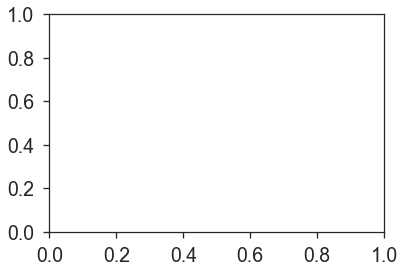

In [15]:
# to extract phase using wavelet analysis

for col in data.columns:
    if 'W' not in col: # ignore columns that do not correspond to sample trajectories
        continue
    traj = get_traj(col)
    wAn.compute_spectrum(traj, Plot = False)
    rdata = wAn.get_maxRidge() # has arrays for inds, power, ridge, time, and z 
    phases = np.angle(rdata['z']) # angle of the complex number component
    # amplitudes = np.abs(rdata['z']) # magnitude of the complex number component

    s = pd.Series(phases) # 1d array of phases with axis labels
    allphases[col] = s

    # r = pd.Series(amplitudes) # 1d array of amplitudes with axis labels
    # allamplitudes[col] = r

In [16]:
# to export order parameter over time

order_parameter = [] # array with order parameter across time
for time in range(len(allphases)):
    allphases_time = allphases.iloc[time,:]
    order_parameter_time = order_par(allphases_time)
    order_parameter.append(order_parameter_time)
order_parameter = pd.DataFrame(data=order_parameter) # dataframe with order parameter across time

order_parameter.to_csv(str(directory) + 'orderParameter/' + str(reporter) + '_' + str(drug_conc) + '.0' + str(drug) + '_' + str(med_duration) + '0+' + str(drug_duration) + '0_' + str(sample_loc) + '.csv')

In [17]:
# linear interpolation of phase of periodic drug pulses
# translated from a Matlab script with the help of Maximilian Beckers (maximilian.beckers@embl.de)

start = first_pulse - math.floor(period_pulse/2)
phase_pulse = np.zeros(int(start+period_pulse+math.ceil(endpoint/period_pulse)*period_pulse))
phase_pulse[0:start] = np.arange((-pi+(period_pulse-start)*2*pi/(period_pulse-1)),pi+pi/(period_pulse-1) ,2*pi/(period_pulse-1))

for n in range(0, math.ceil(endpoint/period_pulse)+1):
    phase_pulse[int(start+n*period_pulse):int(start+period_pulse+n*period_pulse)] = np.arange(-pi,pi+pi/(period_pulse-1),2*pi/(period_pulse-1))
    
phase_pulse = phase_pulse[0:endpoint]
pulsePhase = pd.DataFrame(phase_pulse)

allPhases = allphases.copy()
pulsesPhase = pd.DataFrame(allPhases)

for i in range(len(allphases.columns)):
    pulsesPhase.iloc[:,i] = pulsePhase.iloc[:,0]

num_pulses = 0

for n in range(0,endpoint):    
    if (first_pulse + period_pulse + num_pulses*period_pulse) < endpoint:
        num_pulses = (num_pulses + 1)

In [18]:
# phases from range -pi to pi

allphases_pipi = pd.DataFrame(allphases)

for i in range(len(allphases)):
    for j in range(len(allphases.columns)):
        if allphases_pipi.iloc[i,j] < -1*pi:
            allphases_pipi.iloc[i,j] = allphases_pipi.iloc[i,j] + 2*pi

pulsesPhase_pipi = pd.DataFrame(pulsesPhase)

for i in range(len(pulsesPhase)):
    for j in range(len(pulsesPhase.columns)):
        if pulsesPhase_pipi.iloc[i,j] < -1*pi:
            pulsesPhase_pipi.iloc[i,j] = pulsesPhase_pipi.iloc[i,j] + 2*pi

order parameter for 200mins: 0.39815535697815657
mean phase for 200mins: 1.924854207332942
order parameter for 400mins: 0.530039177537268
mean phase for 400mins: 2.130744074696563
order parameter for 600mins: 0.77320171942872
mean phase for 600mins: 2.8783144897101245
order parameter for 800mins: 0.8319394460151026
mean phase for 800mins: -2.6138734469954388
order parameter for 1000mins: 0.8499116287845591
mean phase for 1000mins: -1.752905946060809
order parameter for 1200mins: 0.8846308405683375
mean phase for 1200mins: -0.7670234020423256


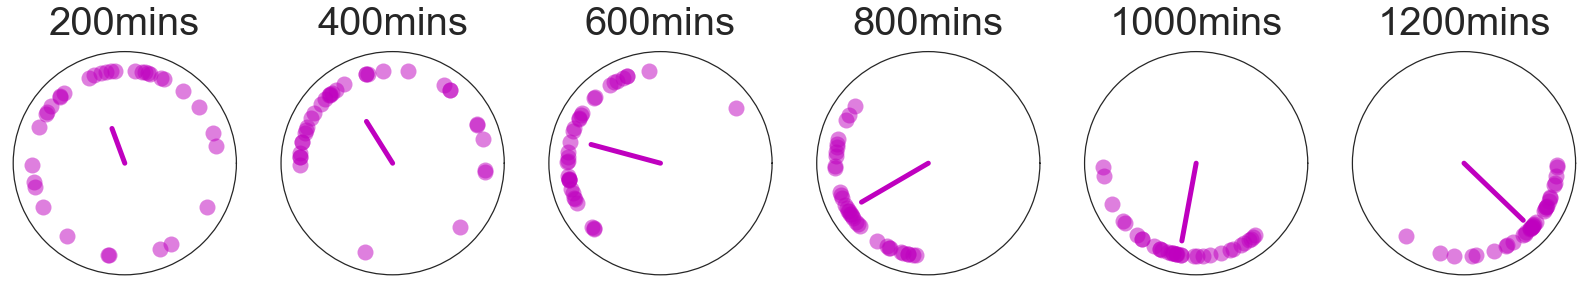

In [19]:
# generating polar plots adapted from script by Gregor Moenke

t_labels = [str(t*dt) + 'mins' for t in t_inds]

ppl.figure(188,figsize=(28,8))
ppl.clf()

fig,axs = ppl.subplots(1,len(t_inds),subplot_kw=dict(projection='polar'),num=188)

for POLARax,t_ind,t_label in zip(axs,t_inds,t_labels):
    
    phis = allphases.iloc[t_ind,:] # phases of all samples for indicated timepoint
    
    Z = sum([e**(phi*1j) for phi in phis])
    Z = Z/len(phis) # normalization
    
    polar_orderParameter = order_par(phis) # calculate order parameter
    # polar_orderParameter_2 = np.abs(Z) # alternative way of calculating order parameter, gives same value as polar_orderParameter
    polar_meanPhase = np.angle(Z)

    print(str('order parameter for ') + str(t_label) + ': ' + str(polar_orderParameter))
    print(str('mean phase for ') + str(t_label) + ': ' + str(polar_meanPhase))

    POLARax.plot(phis,np.ones(len(phis)),'mo', alpha = 0.5, ms = '16') # np.ones for radius = 1, ms = marker size
    #POLARax.set_rmax(1)
    POLARax.grid(False)
    POLARax.plot([0,polar_meanPhase],[0,polar_orderParameter],'m-',alpha = 1, lw = 5)
    
    POLARax.set_xticklabels(())
    POLARax.set_yticklabels(())
    POLARax.set_ylim(0,1.2)
    POLARax.set_title(str(t_label), fontsize = 40)

savefig(str(directory) + 'polarPlot/polarPlot_' + str(reporter) + '_' + str(drug_conc) + '.0' + str(drug) + '_' + str(med_duration) + '0+' + str(drug_duration) + '0_' + str(sample_loc) + '.pdf', bbox_inches = 'tight')
    
ppl.show()

## Calculating phase difference between oscillator and perturbation during entrainment

Phase difference between the signaling oscillation and the periodic perturbation is calculated using the protocol by Paul François (paulf@physics.mcgill.ca), [Cross and Siggia](https://doi.org/10.1103/PhysRevE.72.021910) (**2005**), and [Isomura et al.](https://dx.doi.org/10.1101/gad.294546.116) (**2017**). Briefly, the phase difference ($\Delta\phi$) is defined as:

$$\Delta\phi = \phi(t + T)-\phi(t)$$

where $t$ is the time of perturbation and $T$ is the period of the perturbation (i.e., one cycle after time = $t$). `old_phases` contains the $\phi(t)$, while `new_phases` contains the $\phi(t + T)$. The stroboscopic maps are then plotted as `new_phases` versus `old_phases`. The centroid is determined from the average phases of the final (`old_phase`,`new_phase`) pairs, and the circular standard deviation (circSD) is calculated using the formula:

$$circSD = \sqrt{-2lnR}$$

where $R$ is the first Kuramoto order parameter.



In [21]:
# populate array with old phases and new phases

oldphases = []
newphases = []

second_pulse = first_pulse + period_pulse # note first pulse is skipped because of edge effect in wavelet analysis
endpoint_edgeEffect = endpoint - period_pulse # note a period from the edge is not considered because of edge effect in wavelet analysis

num_pulses = 0

for n in range(0,endpoint):    
    if (second_pulse + period_pulse + num_pulses*period_pulse) < endpoint_edgeEffect:
        oldphase = allphases.iloc[(second_pulse + num_pulses*period_pulse),:] # phase at start of perturbation
        newphase = allphases.iloc[(second_pulse + period_pulse + num_pulses*period_pulse),:] # phase one cycle after perturbation
        num_pulses = (num_pulses + 1)
        oldphases.append(oldphase)
        newphases.append(newphase)

In [22]:
# express old phases and new phases in (1) range from 0 to 2pi and (2) range from -pi to pi

old_phases_02pi = pd.DataFrame(oldphases)
old_phases_pipi = pd.DataFrame(oldphases)

for i in range(len(old_phases_02pi)):
    for j in range(len(old_phases_02pi.columns)):
        if old_phases_02pi.iloc[i,j] < 0:
            old_phases_02pi.iloc[i,j] = old_phases_02pi.iloc[i,j] + 2*pi
            if old_phases_pipi.iloc[i,j] < -1*pi:
                old_phases_pipi.iloc[i,j] = old_phases_pipi.iloc[i,j] + 2*pi

new_phases_02pi = pd.DataFrame(newphases)
new_phases_pipi = pd.DataFrame(newphases)

for i in range(len(new_phases_02pi)):
    for j in range(len(new_phases_02pi.columns)):
        if new_phases_02pi.iloc[i,j] < 0:
            new_phases_02pi.iloc[i,j] = new_phases_02pi.iloc[i,j] + 2*pi
            if new_phases_pipi.iloc[i,j] < -1*pi:
                new_phases_pipi.iloc[i,j] = new_phases_pipi.iloc[i,j] + 2*pi

In [23]:
# get phase difference

phasediff = pd.DataFrame(new_phases_02pi)
phase_diffs = pd.DataFrame(new_phases_02pi)

for i in range(len(new_phases_02pi)):
    for j in range(len(new_phases_02pi.columns)):
        phasediff.iloc[i,j] = new_phases_02pi.iloc[i,j] - old_phases_02pi.iloc[i,j]
        phase_diffs.iloc[i,j] = (np.arctan2(np.sin(phasediff.iloc[i,j]),np.cos(phasediff.iloc[i,j])))

phase_diffs = pd.DataFrame(phase_diffs)

In [25]:
# make a list of last points for determination of centroid, phases from -pi to pi

last_point = len(old_phases_pipi) - 1
last_point_old_phases_pipi = []
last_point_new_phases_pipi = []

for j in range(len(old_phases_pipi.columns)):
    x = old_phases_pipi.iloc[last_point,j] # list of final values of old phases
    y = new_phases_pipi.iloc[last_point,j] # list of final values of new phases
    last_point_old_phases_pipi.append(x)
    last_point_new_phases_pipi.append(y)

In [26]:
# for old phases, get average of x and average of y -- centroid
# from https://stackoverflow.com/questions/491738/how-do-you-calculate-the-average-of-a-set-of-circular-data

x = y = 0

for i in last_point_old_phases_pipi:
    x = x + cos(i)
    y = y + sin(i)

average_angle_old = atan2(y,x)
average_angle_old

-1.9040225974353513

In [27]:
# for new phases, get average of x and average of y -- centroid
# from https://stackoverflow.com/questions/491738/how-do-you-calculate-the-average-of-a-set-of-circular-data

x = y = 0

for i in last_point_new_phases_pipi:
    x = x + cos(i)
    y = y + sin(i)

average_angle_new = atan2(y,x)
average_angle_new

-2.1135818157226853

In [28]:
# to calculate circular standard deviation

old_order_par = order_par(last_point_old_phases_pipi)
new_order_par = order_par(last_point_new_phases_pipi)

circ_SD_old = np.sqrt(-2*np.log(old_order_par))
circ_SD_new = np.sqrt(-2*np.log(new_order_par))

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['ms', 'markersize'] which are all aliases for 'markersize'.  Kept value from 'markersize'
  seen=seen, canon=canonical, used=seen[-1]))


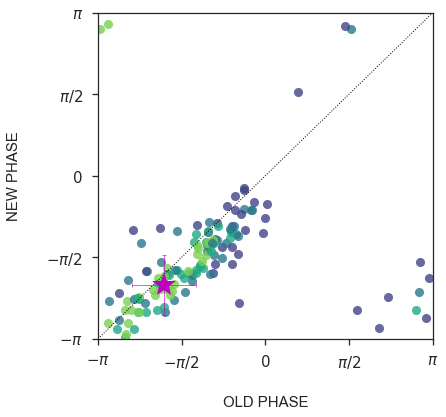

In [29]:
# plot stroboscopic map with centroid and circular standard deviation, color = temporal evolution

# for phases expressed in range -pi to pi

ppl.figure(figsize=(6,6)) # default size is 8,6
ppl.clf()
STROBax = ppl.gca()

ps = linspace(-pi,pi,100)

for j in range(len(old_phases_pipi.columns)):
    sample_num = j + 1
    ncolors_ = len(old_phases_pipi)
    sns.set_palette("viridis", ncolors_)
    
    for i in range(len(old_phases_pipi)):
        STROBax.plot(old_phases_pipi.iloc[i,j], new_phases_pipi.iloc[i,j], 'o', alpha = 0.8)

STROBax.plot(ps,ps,'k:',lw = 1) # diagonal, no phase shift
STROBax.set_xlabel('OLD PHASE', labelpad = 25, fontsize = 15) # old phase
STROBax.set_ylabel('NEW PHASE', labelpad = 25, fontsize = 15)
STROBax.set_xlim((-1*pi,1*pi))
STROBax.set_xticks(arange(-1*pi,1.01*pi,pi/2.)) # if 1*pi (instead of 1.01*pi), there is no label for 1*pi
STROBax.set_xticklabels(['$-\pi$','$-\pi/2$','$0$','$\pi/2$','$\pi$'], fontsize = 15)
STROBax.set_ylim((-1*pi,1*pi))
STROBax.set_yticks(arange(-1*pi,1.01*pi,pi/2.)) # if 1*pi (instead of 1.01*pi), there is no label for 1*pi
STROBax.set_yticklabels(['$-\pi$','$-\pi/2$','$0$','$\pi/2$','$\pi$'], fontsize = 15)

STROBax.plot(average_angle_old, average_angle_new,'m*', lw = 1, ms=15, zorder = 5, markersize = 25) # diagonal, no phase shift
(_, caps, _) = STROBax.errorbar(average_angle_old, average_angle_new, xerr=circ_SD_old, yerr=circ_SD_new, lw = 1, alpha = 0.6, ecolor = 'm', capsize = 2, zorder = 5)

for cap in caps:
    cap.set_markeredgewidth(1)

ppl.savefig(str(directory) + 'stroboscopic/stroboscopic_' + str(reporter) + '_' + str(drug_conc) + '.0' + str(drug) + '_' + str(med_duration) + '0+' + str(drug_duration) + '0_' + str(sample_loc) + '_all+centroid+-circSD_pipi_temporalEvolution.pdf', bbox_inches = 'tight')

In [30]:
new_phases_02pi = pd.DataFrame(newphases)
new_phases_pipi = pd.DataFrame(newphases)

for i in range(len(new_phases_02pi)):
    for j in range(len(new_phases_02pi.columns)):
        if new_phases_02pi.iloc[i,j] < 0:
            new_phases_02pi.iloc[i,j] = new_phases_02pi.iloc[i,j] + 2*pi
            if new_phases_pipi.iloc[i,j] < -1*pi:
                new_phases_pipi.iloc[i,j] = new_phases_pipi.iloc[i,j] + 2*pi

In [31]:
# make a list of last points for determination of centroid, phases from 0 to 2pi

last_point_ = len(old_phases_02pi) - 1
last_point_old_phases_02pi = []
last_point_new_phases_02pi = []

for j in range(len(old_phases_02pi.columns)):
    x = old_phases_02pi.iloc[last_point_,j] # list of final values of old phases
    y = new_phases_02pi.iloc[last_point_,j] # list of final values of new phases
    last_point_old_phases_02pi.append(x)
    last_point_new_phases_02pi.append(y)

In [32]:
# for old phases, get average of x and average of y -- centroid
# from https://stackoverflow.com/questions/491738/how-do-you-calculate-the-average-of-a-set-of-circular-data

x = y = 0

for i in last_point_old_phases_02pi:
    x = x + cos(i)
    y = y + sin(i)

average_angle_old_02pi = atan2(y,x)

if average_angle_old_02pi < 0:
    average_angle_old_02pi = average_angle_old_02pi + 2*pi
average_angle_old_02pi

4.379162709744235

In [33]:
# for new phases, get average of x and average of y -- centroid
# from https://stackoverflow.com/questions/491738/how-do-you-calculate-the-average-of-a-set-of-circular-data

x = y = 0

for i in last_point_new_phases_02pi:
    x = x + cos(i)
    y = y + sin(i)
    
average_angle_new_02pi = atan2(y,x)

if average_angle_new_02pi < 0:
    average_angle_new_02pi = average_angle_new_02pi + 2*pi
average_angle_new_02pi

4.1696034914569005

In [34]:
# to calculate circular standard deviation

old_order_par_02pi = order_par(last_point_old_phases_02pi)
new_order_par_02pi = order_par(last_point_new_phases_02pi)

circ_SD_old_02pi = np.sqrt(-2*np.log(old_order_par_02pi))
circ_SD_new_02pi = np.sqrt(-2*np.log(new_order_par_02pi))

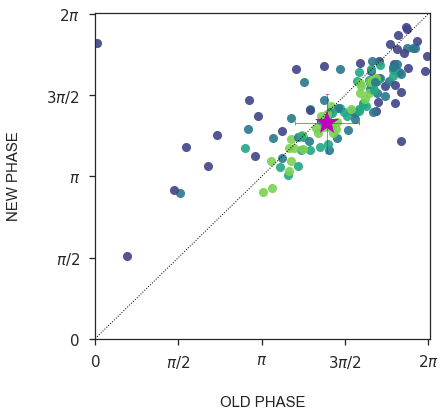

In [35]:
ppl.figure(figsize=(6,6)) # default size is 8,6
ppl.clf()
STROBax = ppl.gca()

ps = linspace(0,2*pi,100)

for j in range(len(old_phases_02pi.columns)):
    sample_num = j + 1
    ncolors_ = len(old_phases_02pi)
    sns.set_palette("viridis", ncolors_)
    
    for i in range(len(old_phases_02pi)):
        STROBax.plot(old_phases_02pi.iloc[i,j], new_phases_02pi.iloc[i,j], 'o', alpha = 0.9)

STROBax.set_xlabel('OLD PHASE', labelpad = 25, fontsize = 15) # old phase
STROBax.set_ylabel('NEW PHASE', labelpad = 25, fontsize = 15)
STROBax.set_xlim((0,2.01*pi))
STROBax.set_xticks(arange(0,2.01*pi,pi/2.)) # if 2*pi (instead of 2.01*pi), there is no label for 2*pi
STROBax.set_xticklabels(['$0$','$\pi/2$','$\pi$','$3\pi/2$','$2\pi$'], fontsize = 15)
STROBax.set_ylim((0,2.01*pi))
STROBax.set_yticks(arange(0,2.01*pi,pi/2.)) # if 2*pi (instead of 2.01*pi), there is no label for 2*pi
STROBax.set_yticklabels(['$0$','$\pi/2$','$\pi$','$3\pi/2$','$2\pi$'], fontsize = 15)
STROBax.plot(ps,ps,'k:',lw = 1) # diagonal, no phase shift
STROBax.plot(average_angle_old_02pi, average_angle_new_02pi,'m*', lw = 1, zorder = 5, markersize = 25) # diagonal, no phase shift
(_, caps, _) = STROBax.errorbar(average_angle_old_02pi, average_angle_new_02pi, xerr=circ_SD_old_02pi, yerr=circ_SD_new_02pi, lw = 1, alpha = 0.6, ecolor = 'm', capsize = 2, zorder = 5)

for cap in caps:
    cap.set_markeredgewidth(1)

ppl.savefig(str(directory) + 'stroboscopic/stroboscopic_' + str(reporter) + '_' + str(drug_conc) + '.0' + str(drug) + '_' + str(med_duration) + '0+' + str(drug_duration) + '0_' + str(sample_loc) + '_all+centroid+-circSD_02pi_temporalEvolution.pdf', bbox_inches = 'tight')